In [1]:

# from
from concurrent.futures import ThreadPoolExecutor
from langchain_core.documents import Document
from PyPDF2 import PdfReader, PdfWriter
from google.genai import types
from google import genai
from typing import List
from tqdm import tqdm
from json import JSONDecodeError
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union
from vertexai.language_models import TextEmbeddingModel
from vertexai.vision_models import Image as vision_model_Image
from vertexai.vision_models import MultiModalEmbeddingModel
from vertexai.generative_models import Image
from vertexai.generative_models import Image as VxImage
from vertexai.generative_models import GenerationConfig, HarmBlockThreshold, HarmCategory, Image, GenerativeModel
# import
import io, re, json, threading
import numpy as np
import pandas as pd
import fitz, cv2, os
import PIL


In [2]:
class Color:
    PURPLE: str = "\033[95m"
    CYAN: str = "\033[96m"
    DARKCYAN: str = "\033[36m"
    BLUE: str = "\033[94m"
    GREEN: str = "\033[92m"
    YELLOW: str = "\033[93m"
    RED: str = "\033[91m"
    BOLD: str = "\033[1m"
    UNDERLINE: str = "\033[4m"
    END: str = "\033[0m"


In [3]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [4]:
PROJECT_ID = "fortunaii"
LOCATION = "us-central1" # Your project location
client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

In [5]:
def get_pdf_reader_and_metadata(pdf_path):
    reader = PdfReader(pdf_path)
    metadata = {
        "total_pages": len(reader.pages),
        "title": reader.metadata.get('/Title', ''),
        "author": reader.metadata.get('/Author', ''),
        "creation_date": reader.metadata.get('/CreationDate', '')
    }
    return reader, metadata

In [6]:
def extract_page(reader, page_number):
    # Check if the page number is valid
    total_pages = len(reader.pages)
    if page_number < 0 or page_number >= total_pages:
        print(f"Page {page_number} is out of range. This PDF has {total_pages} pages.")
        return None
    # Initialize the PDF writer and add the specified page
    writer = PdfWriter()
    writer.add_page(reader.pages[page_number])
    # Write to bytes buffer instead of file
    buffer = io.BytesIO()
    writer.write(buffer)
    return buffer.getvalue()

In [7]:
prompt = """You are tasked with converting a PDF document to text in markdown format. Your goal is to accurately represent the content, structure, and layout of the original PDF while using markdown syntax. Follow these instructions carefully:
To convert this PDF content to markdown format, follow these steps:

1. Document Structure:
      - Preserve the overall structure of the document.
      - Use appropriate markdown syntax for headers, subheaders, and sections.
      - Maintain the original hierarchy of the document.

2. Text Formatting:
      - Convert basic text to plain markdown text.
      - Use markdown syntax for bold (**text**), italic (*text*), and strikethrough (~~text~~) where applicable.
      - Preserve any special characters or symbols as they appear in the original document.

3. Headers:
      - Use the appropriate number of hash symbols (#) to represent different header levels.
      - Example: # for H1, ## for H2, ### for H3, and so on.

4. Paragraphs:
      - Separate paragraphs with a blank line.
      - Preserve any indentation or special formatting within paragraphs.

5. Lists:
      - Use - for unordered lists and 1. 2. 3. for ordered lists.
      - Maintain the original indentation for nested lists.

6. Tables:
      - Convert tables to markdown table format.
      - Use | to separate columns and - to create the header row.
      - Align columns using : in the header row (e.g., |:---:| for center alignment).

7. Links:
      - Convert hyperlinks to markdown format: [link text](URL)

8. Images:
      - For each image/chart in the PDF, insert a placeholder in the following format:
      [Image Description]
      - Provide a full description of the image in place of \"Image Description\".
      - describe the image in detail, like you would describe it to a blind person.

9. Footnotes:
      - Use markdown footnote syntax: [^1] for the reference and [^1]: Footnote text for the footnote content.
      - Place all footnotes at the end of the document.

10. Code Blocks:
      - Use triple backticks (```) to enclose code blocks.
      - Specify the language after the opening backticks if applicable.

11. Blockquotes:
      - Use > to indicate blockquotes.
      - For nested blockquotes, use multiple > symbols.

12. Horizontal Rules:
      - Use three or more hyphens (---) on a line by themselves to create a horizontal rule.

13. Special Elements:
      - If there are any special elements in the PDF (e.g., mathematical equations, diagrams), describe them in plain text within square brackets.

14. Preserve Layout:
      - Maintain the original layout as much as possible, including line breaks and spacing.
      - Use empty lines and appropriate markdown syntax to recreate the visual structure of the document.

Once you have converted the entire PDF content to markdown format.  Ensure that all elements of the original document are accurately represented in the markdown version."""

In [8]:
def _strip_code_fences(s: str) -> str:
    s = s.strip()
    # Remove ```json ... ``` or ``` ... ```
    if s.startswith("```"):
        s = re.sub(r"^```[a-zA-Z0-9_-]*\s*", "", s)
        s = re.sub(r"\s*```$", "", s)
    return s.strip()

def _extract_first_json_object(s: str) -> str | None:
    """
    Best-effort: find the first {...} block (non-greedy).
    Not perfect for nested braces in strings, but helps with common cases.
    """
    m = re.search(r"\{.*\}", s, flags=re.DOTALL)
    return m.group(0) if m else None

def generate(page_pdf_bytes: bytes, metadata: dict) -> Document:
    document_part = types.Part.from_bytes(data=page_pdf_bytes, mime_type="application/pdf")

    model = "gemini-2.0-flash"
    contents = [
        types.Content(
            role="user",
            parts=[
                document_part,
                types.Part.from_text(text="convert this file")
            ],
        ),
    ]

    generate_content_config = types.GenerateContentConfig(
        temperature=0,
        top_p=0.95,
        max_output_tokens=8192,
        response_modalities=["TEXT"],
        safety_settings=[
            types.SafetySetting(category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
            types.SafetySetting(category="HARM_CATEGORY_HARASSMENT", threshold="OFF"),
        ],
        response_mime_type="application/json",
        response_schema={
            "type": "OBJECT",
            "properties": {
                "page_content": {"type": "STRING", "description": "The content of the document."}
            },
            "required": ["page_content"],
        },
        system_instruction=[types.Part.from_text(text=prompt)],
    )

    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=generate_content_config,
    )

    # 1) Best path: structured output from SDK
    if hasattr(response, "parsed") and response.parsed:
        page_content = response.parsed.get("page_content", "")
        return Document(page_content=page_content, metadata=metadata)

    # 2) Fallback: try to parse response.text
    raw = (getattr(response, "text", "") or "").strip()
    raw = _strip_code_fences(raw)

    # Sometimes the API returns valid JSON directly
    try:
        obj = json.loads(raw)
        return Document(page_content=obj.get("page_content", raw), metadata=metadata)
    except JSONDecodeError:
        pass

    # 3) Salvage: extract first JSON object from a messy response
    maybe_json = _extract_first_json_object(raw)
    if maybe_json:
        maybe_json = _strip_code_fences(maybe_json)
        try:
            obj = json.loads(maybe_json)
            return Document(page_content=obj.get("page_content", raw), metadata=metadata)
        except JSONDecodeError:
            pass

    # 4) Last resort: treat it as plain markdown/text
    return Document(page_content=raw, metadata=metadata)

In [9]:
# Signle Page testing
pdf_path = "./data/ym358a.pdf"
page_number = 10  # Remember, the first page is 0
reader, metadata = get_pdf_reader_and_metadata(pdf_path)
metadata['page'] = page_number + 1
b64Page = extract_page(reader, page_number)
document_page = generate(b64Page, metadata)
print(document_page)

page_content='# 1. SAFETY PRECAUTIONS

# 1. SAFETY PRECAUTIONS

## 1. About The Operation Manual

The operation manual presents messages that help the operator remain aware of potential hazards and possible tractor damage in operating and servicing the tractor. Carefully study all of the information in the operation manual so that the operator can avoid personal injury or property damage.

[Image of a tractor with labels indicating 'RIGHT' pointing to the right side of the tractor, 'REAR' pointing to the back, 'LEFT' pointing to the left side, and 'FRONT' pointing to the front. The tractor is a detailed line drawing, showing its various components like wheels, engine, seat, and protective frame.]

**NOTE**

*   Unless otherwise stated, the expressions right hand side, left hand side, front side and rear side, used throughout the operation manual are relative to the operator's position.

## 2. Safety Alert Symbol

[Image of an exclamation mark inside a triangle]

The safety alert symbol

In [10]:
def process_all_pages(pdf_path):
    # Initialize the PDF reader and get metadata
    reader, metadata = get_pdf_reader_and_metadata(pdf_path)
    documents = []
    # Process each page
    for page_number in tqdm(range(len(reader.pages)), desc="Processing pages"):
        # Update metadata for current page
        page_metadata = metadata.copy()
        page_metadata['page'] = page_number + 1
        # Extract and process page
        b64_page = extract_page(reader, page_number)
        document_page = generate(b64_page, page_metadata)
        documents.append(document_page)
    return documents

In [11]:
# # Process all pages in the PDF and get an array of Document objects
# pdf_path = "./data/ym358a.pdf"
# all_documents = process_all_pages(pdf_path)

In [12]:
def process_page(args) -> tuple[int, Document]:
    page_number, pdf_path, metadata = args
    reader = PdfReader(pdf_path)
    # Update metadata for current page
    page_metadata = metadata.copy()
    page_metadata['page'] = page_number + 1
    # Extract and process page
    b64_page = extract_page(reader, page_number)
    document_page = generate(b64_page, page_metadata)
    return page_number, document_page

In [13]:
def process_all_pages_parallel(pdf_path: str, batch_size: int = 3) -> List[Document]:
    # Get initial metadata and page count
    reader = PdfReader(pdf_path)
    total_pages = len(reader.pages)
    metadata = {
        "total_pages": total_pages,
        "title": reader.metadata.get('/Title', ''),
        "author": reader.metadata.get('/Author', ''),
        "creation_date": reader.metadata.get('/CreationDate', '')
    }
    documents = [None] * total_pages  # Pre-allocate list with correct size
    # Create progress bar
    pbar = tqdm(total=total_pages, desc="Processing pages")
    pbar_lock = threading.Lock()

    def process_batch(start_idx: int, end_idx: int):
        with ThreadPoolExecutor(max_workers=batch_size) as executor:
            # Create arguments for each page in the batch
            batch_args = [(i, pdf_path, metadata) for i in range(start_idx, min(end_idx, total_pages))]
            # Process the batch in parallel
            for page_number, document in executor.map(process_page, batch_args):
                documents[page_number] = document
                with pbar_lock:
                    pbar.update(1)

    # Process pages in batches
    try:
        for batch_start in range(0, total_pages, batch_size):
            batch_end = batch_start + batch_size
            process_batch(batch_start, batch_end)
    finally:
        pbar.close()

    return documents

In [14]:
# pdf_path = "./data/ym358a.pdf"
# batch_size = 70
# all_documents = process_all_pages_parallel(pdf_path, batch_size)

In [15]:
# Signle Page testing
pdf_path = "./data/ym358a.pdf"
page_number = 10  # Remember, the first page is 0
reader, metadata = get_pdf_reader_and_metadata(pdf_path)
metadata['page'] = page_number + 1
b64Page = extract_page(reader, page_number)
# document_page = generate(b64Page, metadata)
# print(document_page)

In [16]:
text_embedding_model = TextEmbeddingModel.from_pretrained("text-embedding-004")
multimodal_embedding_model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

In [17]:
def get_text_embedding_from_text_embedding_model(text: str, return_array: Optional[bool] = False):
    embeddings = text_embedding_model.get_embeddings([text])
    text_embedding = [embedding.values for embedding in embeddings][0]
    if return_array:
        text_embedding = np.fromiter(text_embedding, dtype=float)
    return text_embedding

In [18]:
def get_image_embedding_from_multimodal_embedding_model(image_uri: str, embedding_size: int = 512, text: Optional[str] = None, return_array: Optional[bool] = False):
    image = vision_model_Image.load_from_file(image_uri)
    embeddings = multimodal_embedding_model.get_embeddings(image=image, contextual_text=text, dimension=embedding_size)  # 128, 256, 512, 1408
    image_embedding = embeddings.image_embedding
    if return_array:
        image_embedding = np.fromiter(image_embedding, dtype=float)
    return image_embedding

In [19]:
def get_page_text_embedding(text_data: Union[dict, str]) -> dict:
    embeddings_dict = {}
    if not text_data: return embeddings_dict
    if isinstance(text_data, dict):
        for chunk_number, chunk_value in text_data.items():
            text_embed = get_text_embedding_from_text_embedding_model(text=chunk_value)
            embeddings_dict[chunk_number] = text_embed
    else:
        text_embed = get_text_embedding_from_text_embedding_model(text=text_data)
        embeddings_dict["text_embedding"] = text_embed

    return embeddings_dict

In [20]:
def get_text_overlapping_chunk(text: str, character_limit: int = 1000, overlap: int = 100):
    if overlap > character_limit:
        raise ValueError("Overlap cannot be larger than character limit.")
    chunk_number = 1
    chunked_text_dict = {}
    for i in range(0, len(text), character_limit - overlap):
        end_index = min(i + character_limit, len(text))
        chunk = text[i:end_index]
        # Encode and decode for consistent encoding
        chunked_text_dict[chunk_number] = chunk.encode("ascii", "ignore").decode("utf-8", "ignore")
        # Increment chunk number
        chunk_number += 1
    return chunked_text_dict


In [21]:
def get_chunk_text_metadata(page_content, overlap: int = 100, character_limit: int = 1000, embedding_size: int = 128) -> dict:
    if overlap > character_limit:
        raise ValueError("Overlap cannot be larger than character limit.")
    page_text_embeddings_dict = get_page_text_embedding(page_content)
    chunked_text_dict: dict = get_text_overlapping_chunk(page_content, character_limit, overlap)
    chunk_embeddings_dict: dict = get_page_text_embedding(chunked_text_dict)
    return page_content, page_text_embeddings_dict, chunked_text_dict, chunk_embeddings_dict

In [22]:
def find_and_crop_blocks(page_img_path, out_dir="./out_images", min_area=0.03, delete_original=True):
    os.makedirs(out_dir, exist_ok=True)
    img = cv2.imread(page_img_path)
    if img is None:
        raise ValueError(f"Could not read {page_img_path}")

    H, W = img.shape[:2]
    page_area = H * W

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thr = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
    connected = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=2)
    cnts, _ = cv2.findContours(connected, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    crops = []
    base = os.path.splitext(os.path.basename(page_img_path))[0]
    idx = 1

    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if (w * h) < (min_area * page_area):
            continue

        crop = img[y:y+h, x:x+w]
        out_path = os.path.join(out_dir, f"{base}_crop_{idx:02d}.png")
        ok = cv2.imwrite(out_path, crop)
        if ok:
            crops.append(out_path)
            idx += 1

    # delete original ONCE (after loop), and don't crash if already deleted
    if delete_original and os.path.exists(page_img_path):
        try:
            os.remove(page_img_path)
        except FileNotFoundError:
            pass

    return crops

In [23]:
def get_image_for_gemini(image_path: str):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"{image_path} not found")
    image_for_gemini = VxImage.load_from_file(image_path)
    return image_for_gemini, image_path

In [24]:
def extract_embedded_images(pdf_path: str, out_dir: str = "./images"):
    os.makedirs(out_dir, exist_ok=True)
    doc = fitz.open(pdf_path)
    saved = []

    for page_index in range(len(doc)):
        page = doc[page_index]
        image_list = page.get_images(full=True)
        for img_i, img in enumerate(image_list, start=1):
            xref = img[0]
            base = doc.extract_image(xref)
            img_bytes = base["image"]
            ext = base.get("ext", "bin")
            out_path = os.path.join(out_dir, f"page_{page_index+1:03d}_img_{img_i:02d}.{ext}")
            with open(out_path, "wb") as f:
                f.write(img_bytes)
            find_and_crop_blocks(out_path)
            saved.append(out_path)
    return saved


In [25]:
def extract_page_images_pymupdf(doc: fitz.Document, page_number: int, out_dir="./out_images"):
    os.makedirs(out_dir, exist_ok=True)
    page = doc[page_number]
    images = page.get_images(full=True)
    saved = []
    for img_i, img in enumerate(images, start=1):
        xref = img[0]
        base = doc.extract_image(xref)
        ext = base.get("ext", "bin")
        img_bytes = base["image"]
        out_path = os.path.join(out_dir, f"page_{page_number+1:03d}_img_{img_i:02d}.{ext}")
        with open(out_path, "wb") as f:
            f.write(img_bytes)
        cropped_imgs = find_and_crop_blocks(out_path, out_dir=out_dir)
        saved.append((cropped_imgs, xref))
    return saved, images

In [26]:
def get_gemini_response(
    generative_multimodal_model,
    model_input: List[str],
    stream: bool = True,
    generation_config: Optional[GenerationConfig] = GenerationConfig(
        temperature=0.2, max_output_tokens=2048
    ),
    safety_settings: Optional[dict] = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    },
) -> str:
    response = generative_multimodal_model.generate_content(
        model_input,
        generation_config=generation_config,
        stream=stream,
        safety_settings=safety_settings,
    )
    if not stream:
        try:
            return (getattr(response, "text", None) or "").strip()
        except Exception as e:
            print(
                "Exception occurred while calling gemini (non-stream). "
                "Try lowering safety thresholds [safety_settings: BLOCK_NONE ] if not already done. -----",
                e,
            )
            return "Exception occurred"

    response_list: List[str] = []
    for chunk in response:
        try:
            if getattr(chunk, "text", None):
                response_list.append(chunk.text)
        except Exception as e:
            print(
                "Exception occurred while calling gemini (stream). "
                "Try lowering safety thresholds [safety_settings: BLOCK_NONE ] if not already done. -----",
                e,
            )
            response_list.append("Exception occurred")
            continue

    return "".join(response_list).strip()

Configurations

In [27]:
text_model = GenerativeModel("gemini-2.0-flash")
generative_multimodal_model =text_model
multimodal_model_flash = text_model
generation_config = GenerationConfig(temperature=0.2)

In [28]:
image_description_prompt = str(
    "Explain what is going on in the image.\n"
     "If it's a table, extract all elements of the table.\n"
    "If it's a graph, explain the findings in the graph.\n"
    "Do not include any numbers that are not mentioned in the image.\n"
)

In [29]:
def generate_image_description(image_for_gemini: VxImage):
    return get_gemini_response(
        generative_multimodal_model,
        model_input=[image_description_prompt, image_for_gemini],
        generation_config=generation_config,
        safety_settings=None,
        stream=True,
    )

In [30]:

def get_text_metadata_df(
    filename: str, text_metadata: Dict[Union[int, str], Dict]
) -> pd.DataFrame:
    final_data_text: List[Dict] = []

    for key, values in text_metadata.items():
        for chunk_number, chunk_text in values["chunked_text_dict"].items():
            data: Dict = {}
            data["file_name"] = filename
            data["page_num"] = int(key) + 1
            data["text"] = values["text"]
            data["text_embedding_page"] = values["page_text_embeddings"][
                "text_embedding"
            ]
            data["chunk_number"] = chunk_number
            data["chunk_text"] = chunk_text
            data["text_embedding_chunk"] = values["chunk_embeddings_dict"][chunk_number]

            final_data_text.append(data)

    return_df = pd.DataFrame(final_data_text)
    return_df = return_df.reset_index(drop=True)
    return return_df


def get_image_metadata_df(
    filename: str, image_metadata: Dict[Union[int, str], Dict]
) -> pd.DataFrame:

    final_data_image: List[Dict] = []
    for key, values in image_metadata.items():
        for _, image_values in values.items():
            data: Dict = {}
            data["file_name"] = filename
            data["page_num"] = int(key) + 1
            data["img_num"] = int(image_values["img_num"])
            data["img_path"] = image_values["img_path"]
            data["img_desc"] = image_values["img_desc"]

            data["mm_embedding_from_img_only"] = image_values[
                "mm_embedding_from_img_only"
            ]
            data["text_embedding_from_image_description"] = image_values[
                "text_embedding_from_image_description"
            ]
            final_data_image.append(data)

    return_df = pd.DataFrame(final_data_image).dropna()
    return_df = return_df.reset_index(drop=True)
    return return_df


In [31]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import os
import fitz
from PyPDF2 import PdfReader

def process_one_page(pdf_path: str, page_number: int, base_metadata: dict, out_root: str):
    # IMPORTANT: open these inside the thread
    reader = PdfReader(pdf_path)
    doc = fitz.open(pdf_path)
    # --- TEXT ---
    page_metadata = base_metadata.copy()
    page_metadata["page"] = page_number + 1

    page_bytes = extract_page(reader, page_number)
    document_page = generate(page_bytes, page_metadata)

    text, page_text_embeddings_dict, chunked_text_dict, chunk_embeddings_dict = get_chunk_text_metadata(
        document_page.page_content
    )

    text_payload = {
        "text": text,
        "page_text_embeddings": page_text_embeddings_dict,
        "chunked_text_dict": chunked_text_dict,
        "chunk_embeddings_dict": chunk_embeddings_dict,
    }

    # --- IMAGES ---
    # Use a unique output folder per page to avoid collisions
    pdf_stem = os.path.splitext(os.path.basename(pdf_path))[0]
    page_out_dir = os.path.join(out_root, pdf_stem, f"page_{page_number+1:03d}")
    os.makedirs(page_out_dir, exist_ok=True)

    saved_imgs, images = extract_page_images_pymupdf(doc, page_number, out_dir=page_out_dir)

    image_payload = {}
    for image_no, _img in enumerate(images):
        image_number = int(image_no + 1)

        # saved_imgs is [(cropped_imgs, xref), ...]
        # cropped_imgs is a list of paths. pick first crop if exists.
        cropped_list = saved_imgs[image_no][0]
        if not cropped_list:
            continue

        image_path = cropped_list[0]
        image_for_gemini, image_name = get_image_for_gemini(image_path)
        if image_for_gemini is None:
            continue

        desc = generate_image_description(image_for_gemini)
        mm_embed = get_image_embedding_from_multimodal_embedding_model(image_uri=image_name, embedding_size=128)
        desc_text_embed = get_text_embedding_from_text_embedding_model(text=desc)

        image_payload[image_number] = {
            "img_num": image_number,
            "img_path": image_name,
            "img_desc": desc,
            "mm_embedding_from_img_only": mm_embed,
            "text_embedding_from_image_description": desc_text_embed,
        }

    doc.close()
    return page_number, text_payload, image_payload

In [32]:
from tqdm import tqdm

def process_pdf_parallel(pdf_path: str, max_workers: int = 6, out_root: str = "./out_images"):
    # base metadata (read once on main thread)
    reader0 = PdfReader(pdf_path)
    total_pages = len(reader0.pages)
    base_metadata = {
        "total_pages": total_pages,
        "title": reader0.metadata.get("/Title", "") if reader0.metadata else "",
        "author": reader0.metadata.get("/Author", "") if reader0.metadata else "",
        "creation_date": reader0.metadata.get("/CreationDate", "") if reader0.metadata else "",
    }

    text_metadata = {}
    image_metadata = {}

    # progress bar + lock for safe updates
    pbar = tqdm(total=total_pages, desc=f"Processing pages (parallel)")

    pbar_lock = threading.Lock()

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = [
            ex.submit(process_one_page, pdf_path, p, base_metadata, out_root)
            for p in range(total_pages)
        ]

        for fut in as_completed(futures):
            page_number, text_payload, image_payload = fut.result()

            text_metadata[page_number] = text_payload
            image_metadata[page_number] = image_payload

            with pbar_lock:
                pbar.update(1)

    pbar.close()

    # Build your dataframes as before
    file_name = os.path.basename(pdf_path)
    text_df = get_text_metadata_df(file_name, text_metadata)
    image_df = get_image_metadata_df(file_name, image_metadata)
    return text_df, image_df

In [33]:
text_metadata_df_final, image_metadata_df_final = pd.DataFrame(), pd.DataFrame()
text_metadata_df, image_metadata_df = process_pdf_parallel("./data/ym358a.pdf", max_workers=6, out_root="./out_images")

Processing pages (parallel): 100%|██████████| 156/156 [10:43<00:00,  4.13s/it]


In [36]:

text_metadata_df_final = pd.concat([text_metadata_df_final, text_metadata_df], axis=0)
image_metadata_df_final = pd.concat(
    [
        image_metadata_df_final,
        image_metadata_df.drop_duplicates(subset=["img_desc"]),
    ],
    axis=0,
)

text_metadata_df_final = text_metadata_df_final.reset_index(drop=True)
image_metadata_df_final = image_metadata_df_final.reset_index(drop=True)

In [34]:
# text_metadata_df_final, image_metadata_df_final = pd.DataFrame(), pd.DataFrame()

# pdf_folder = "./data/"
# pdf_folder = os.listdir(pdf_folder)
# pdf_folder = [os.path.join("./data/", file) for file in pdf_folder if file.endswith(".pdf")]

# for pdf in pdf_folder:
#     print(f"Processing {pdf}...")
#     reader, metadata = get_pdf_reader_and_metadata(pdf)
#     doc = fitz.open(pdf)

#     # metadata
#     file_name = pdf_path.split("/")[-1]
#     text_metadata: Dict[Union[int, str], Dict] = {}
#     image_metadata: Dict[Union[int, str], Dict] = {}


#     for page_number in tqdm(range(len(reader.pages)), desc="Processing pages"):

#         # --- TEXT via Gemini (your existing path) ---
#         page_metadata = metadata.copy()
#         page_metadata["page"] = page_number + 1

#         page_bytes = extract_page(reader, page_number)
#         document_page = generate(page_bytes, page_metadata)

#         text, page_text_embeddings_dict, chunked_text_dict, chunk_embeddings_dict = get_chunk_text_metadata(document_page.page_content)
#         text_metadata[page_number] = {
#             "text": text,
#             "page_text_embeddings": page_text_embeddings_dict,
#             "chunked_text_dict": chunked_text_dict,
#             "chunk_embeddings_dict": chunk_embeddings_dict,
#         }

#         # --- IMAGES via PyMuPDF ---
#         saved_imgs, images = extract_page_images_pymupdf(doc, page_number, out_dir="./out_images")
#         image_metadata[page_number] = {}

#         for image_no, image in enumerate(images):
#             image_number = int(image_no + 1)
#             image_metadata[page_number][image_number] = {}

#             image_for_gemini, image_name = get_image_for_gemini(saved_imgs[image_no][0][0])
#             if image_for_gemini is None:
#                 print(f"Failed to save image for Gemini: page {page_number+1}, image {image_no+1}")
#                 continue

#             # generate image desc using gemini
#             result = generate_image_description(image_for_gemini)
#             image_embedding = get_image_embedding_from_multimodal_embedding_model(image_uri=image_name, embedding_size=128)
#             image_description_text_embedding = get_text_embedding_from_text_embedding_model(text=result)

#             image_metadata[page_number][image_number] = {
#                 "img_num": image_number,
#                 "img_path": image_name,
#                 "img_desc": result,
#                 "mm_embedding_from_img_only": image_embedding,
#                 "text_embedding_from_image_description": image_description_text_embedding,
#             }

#     text_metadata_df = get_text_metadata_df(file_name, text_metadata)
#     image_metadata_df = get_image_metadata_df(file_name, image_metadata)

#     text_metadata_df_final = pd.concat([text_metadata_df_final, text_metadata_df], axis=0)
#     image_metadata_df_final = pd.concat(
#         [
#             image_metadata_df_final,
#             image_metadata_df.drop_duplicates(subset=["img_desc"]),
#         ],
#         axis=0,
#     )

#     text_metadata_df_final = text_metadata_df_final.reset_index(drop=True)
#     image_metadata_df_final = image_metadata_df_final.reset_index(drop=True)


Processing ./data/ym358a.pdf...


Processing pages:   1%|▏         | 2/156 [00:27<34:50, 13.57s/it]


KeyboardInterrupt: 

In [37]:
text_metadata_df_final.head()

file_name  page_num                                               text  \
0  ym358a.pdf         1  [Image of two downward-pointing chevrons stack...   
1  ym358a.pdf         2  In case of exporting this product and providin...   
2  ym358a.pdf         3  # INTRODUCTION\n\nWelcome to the World of Yanm...   
3  ym358a.pdf         3  # INTRODUCTION\n\nWelcome to the World of Yanm...   
4  ym358a.pdf         3  # INTRODUCTION\n\nWelcome to the World of Yanm...   

                                 text_embedding_page  chunk_number  \
0  [0.006402199622243643, 0.0014444113476201892, ...             1   
1  [-0.04351752996444702, 0.03253353014588356, -0...             1   
2  [-0.006558472290635109, -0.0040471600368618965...             1   
3  [-0.006558472290635109, -0.0040471600368618965...             2   
4  [-0.006558472290635109, -0.0040471600368618965...             3   

                                          chunk_text  \
0  [Image of two downward-pointing chevrons stack...   
1  In case of exporting this product and providin...   
2  # INTRODUCTION\n\nWelcome to the World of Yanm...   
3   with the tractor, also carefully study the op...   
4  51R.\n\nAll information, descriptions, specifi...   

                                text_embedding_chunk  
0  [0.006402199622243643, 0.0014444113476201892, ...  
1  [-0.04351752996444702, 0.03253353014588356, -0...  
2  [-0.01778312213718891, -0.019312173128128052, ...  
3  [-0.00029282347531989217, 0.002170423278585076...  
4  [-0.01911170594394207, 0.020060095936059952, -...

In [38]:
image_metadata_df_final.head()


file_name  page_num  img_num  \
0  ym358a.pdf         1        1   
1  ym358a.pdf         2        1   
2  ym358a.pdf         3        1   
3  ym358a.pdf         4        1   
4  ym358a.pdf         9        1   

                                            img_path  \
0  ./out_images/ym358a/page_001/page_001_img_01_c...   
1  ./out_images/ym358a/page_002/page_002_img_01_c...   
2  ./out_images/ym358a/page_003/page_003_img_01_c...   
3  ./out_images/ym358a/page_004/page_004_img_01_c...   
4  ./out_images/ym358a/page_009/page_009_img_01_c...   

                                            img_desc  \
0                The image shows two black chevrons.   
1  The image contains a warning message. It state...   
2  The image is a welcome message for the Yanmar ...   
3  The image shows a collection of pictographs wi...   
4  The image is a table of contents. Here are the...   

                          mm_embedding_from_img_only  \
0  [0.0603338, -0.0108775068, 0.0535922125, -0.06...   
1  [0.0113806603, -0.00173386268, 0.0479720943, -...   
2  [0.0496040173, -0.0192003883, 0.0283472259, -0...   
3  [0.0153290993, -0.0430276021, -0.0325712524, -...   
4  [-0.0316379331, -0.0888771713, -0.0176272187, ...   

               text_embedding_from_image_description  
0  [0.019540047273039818, 0.05213338881731033, 0....  
1  [-0.03159286081790924, 0.025906039401888847, -...  
2  [-0.01368661317974329, 0.00973102729767561, -0...  
3  [0.011848906986415386, 0.013313832692801952, -...  
4  [-0.005431387573480606, 0.0115917157381773, -0...

In [39]:
def get_user_query_text_embeddings(user_query: str) -> np.ndarray:
    return get_text_embedding_from_text_embedding_model(user_query)

In [40]:
def get_user_query_image_embeddings(
    image_query_path: str, embedding_size: int
) -> np.ndarray:
    return get_image_embedding_from_multimodal_embedding_model(
        image_uri=image_query_path, embedding_size=embedding_size
    )

In [41]:
def get_cosine_score(
    dataframe: pd.DataFrame, column_name: str, input_text_embed: np.ndarray
) -> float:
    text_cosine_score = round(np.dot(dataframe[column_name], input_text_embed), 2)
    return text_cosine_score

In [42]:
def print_text_to_image_citation(
    final_images: Dict[int, Dict[str, Any]], print_top: bool = True
) -> None:
    color = Color()
    for imageno, image_dict in final_images.items():
        print(
            color.RED + f"Citation {imageno + 1}:",
            "Matched image path, page number and page text: \n" + color.END,
        )
        print(color.BLUE + "score: " + color.END, image_dict["cosine_score"])
        print(color.BLUE + "file_name: " + color.END, image_dict["file_name"])
        print(color.BLUE + "path: " + color.END, image_dict["img_path"])
        print(color.BLUE + "page number: " + color.END, image_dict["page_num"])
        print(
            color.BLUE + "page text: " + color.END, "\n".join(image_dict["page_text"])
        )
        print(
            color.BLUE + "image description: " + color.END,
            image_dict["image_description"],
        )
        if print_top and imageno == 0:
            break


In [43]:

def print_text_to_text_citation(
    final_text: Dict[int, Dict[str, Any]],
    print_top: bool = True,
    chunk_text: bool = True,
) -> None:
    color = Color()
    for textno, text_dict in final_text.items():
        print(color.RED + f"Citation {textno + 1}:", "Matched text: \n" + color.END)
        print(color.BLUE + "score: " + color.END, text_dict["cosine_score"])
        print(color.BLUE + "file_name: " + color.END, text_dict["file_name"])
        print(color.BLUE + "page_number: " + color.END, text_dict["page_num"])
        if chunk_text:
            print(color.BLUE + "chunk_number: " + color.END, text_dict["chunk_number"])
            print(color.BLUE + "chunk_text: " + color.END, text_dict["chunk_text"])
        else:
            print(color.BLUE + "page text: " + color.END, text_dict["page_text"])
        if print_top and textno == 0:
            break


In [44]:

def get_similar_image_from_query(
    text_metadata_df: pd.DataFrame,
    image_metadata_df: pd.DataFrame,
    query: str = "",
    image_query_path: str = "",
    column_name: str = "",
    image_emb: bool = True,
    top_n: int = 3,
    embedding_size: int = 128,
) -> Dict[int, Dict[str, Any]]:
    if image_emb:
        user_query_image_embedding = get_user_query_image_embeddings(
            image_query_path, embedding_size
        )
        cosine_scores = image_metadata_df.apply(
            lambda x: get_cosine_score(x, column_name, user_query_image_embedding),
            axis=1,
        )
    else:
        user_query_text_embedding = get_user_query_text_embeddings(query)
        cosine_scores = image_metadata_df.apply(
            lambda x: get_cosine_score(x, column_name, user_query_text_embedding),
            axis=1,
        )

    cosine_scores = cosine_scores[cosine_scores < 1.0]

    top_n_cosine_scores = cosine_scores.nlargest(top_n).index.tolist()
    top_n_cosine_values = cosine_scores.nlargest(top_n).values.tolist()

    final_images: Dict[int, Dict[str, Any]] = {}

    for matched_imageno, indexvalue in enumerate(top_n_cosine_scores):
        final_images[matched_imageno] = {}
        final_images[matched_imageno]["cosine_score"] = top_n_cosine_values[
            matched_imageno
        ]
        final_images[matched_imageno]["image_object"] = Image.load_from_file(
            image_metadata_df.iloc[indexvalue]["img_path"]
        )
        final_images[matched_imageno]["file_name"] = image_metadata_df.iloc[indexvalue][
            "file_name"
        ]
        final_images[matched_imageno]["img_path"] = image_metadata_df.iloc[indexvalue][
            "img_path"
        ]
        final_images[matched_imageno]["page_num"] = image_metadata_df.iloc[indexvalue][
            "page_num"
        ]
        final_images[matched_imageno]["page_text"] = np.unique(
            text_metadata_df[
                (
                    text_metadata_df["page_num"].isin(
                        [final_images[matched_imageno]["page_num"]]
                    )
                )
                & (
                    text_metadata_df["file_name"].isin(
                        [final_images[matched_imageno]["file_name"]]
                    )
                )
            ]["text"].values
        )
        final_images[matched_imageno]["image_description"] = image_metadata_df.iloc[
            indexvalue
        ]["img_desc"]

    return final_images

In [45]:
def get_similar_text_from_query(
    query: str,
    text_metadata_df: pd.DataFrame,
    column_name: str = "",
    top_n: int = 3,
    chunk_text: bool = True,
    print_citation: bool = False,
) -> Dict[int, Dict[str, Any]]:
    if column_name not in text_metadata_df.columns:
        raise KeyError(f"Column '{column_name}' not found in the 'text_metadata_df'")

    query_vector = get_user_query_text_embeddings(query)
    cosine_scores = text_metadata_df.apply(
        lambda row: get_cosine_score(
            row,
            column_name,
            query_vector,
        ),
        axis=1,
    )

    top_n_indices = cosine_scores.nlargest(top_n).index.tolist()
    top_n_scores = cosine_scores.nlargest(top_n).values.tolist()

    final_text: Dict[int, Dict[str, Any]] = {}

    for matched_textno, index in enumerate(top_n_indices):
        final_text[matched_textno] = {}
        final_text[matched_textno]["file_name"] = text_metadata_df.iloc[index][
            "file_name"
        ]
        final_text[matched_textno]["page_num"] = text_metadata_df.iloc[index][
            "page_num"
        ]
        final_text[matched_textno]["cosine_score"] = top_n_scores[matched_textno]

        if chunk_text:
            final_text[matched_textno]["chunk_number"] = text_metadata_df.iloc[index][
                "chunk_number"
            ]
            final_text[matched_textno]["chunk_text"] = text_metadata_df["chunk_text"][
                index
            ]
        else:
            final_text[matched_textno]["text"] = text_metadata_df["text"][index]

    if print_citation:
        print_text_to_text_citation(final_text, chunk_text=chunk_text)

    return final_text

In [46]:
def display_images(
    images: Iterable[Union[str, PIL.Image.Image]], resize_ratio: float = 0.5
) -> None:
    # Convert paths to PIL images if necessary
    pil_images = []
    for image in images:
        if isinstance(image, str):
            pil_images.append(PIL.Image.open(image))
        else:
            pil_images.append(image)

    # Resize and display each image
    for img in pil_images:
        original_width, original_height = img.size
        new_width = int(original_width * resize_ratio)
        new_height = int(original_height * resize_ratio)
        resized_img = img.resize((new_width, new_height))
        display(resized_img)
        print("\n")


Usages

In [47]:
def search_text(
        query: str,
        *,
        top_n: int = 3,
        column_name: str = "text_embedding_chunk",
        chunk_text: bool = True,
    ) -> Dict[Any, Dict[str, Any]]:
        return get_similar_text_from_query(
            query,
            text_metadata_df,  # type: ignore
            column_name=column_name,
            top_n=top_n,
            chunk_text=chunk_text,
        )

In [48]:
def search_images_by_description_text(
        query: str,
        *,
        top_n: int = 3,
        column_name: str = "text_embedding_from_image_description",
        embedding_size: Optional[int] = None,
    ) -> Dict[Any, Dict[str, Any]]:
        return get_similar_image_from_query(
            text_metadata_df,  # type: ignore
            image_metadata_df,  # type: ignore
            query=query,
            column_name=column_name,
            image_emb=False,
            top_n=top_n,
            embedding_size=embedding_size,
        )

In [49]:
def search_images_by_image_embedding(
        query: str,
        image_query_path: str,
        *,
        top_n: int = 3,
        column_name: str = "mm_embedding_from_img_only",
        embedding_size: Optional[int] = None,
    ) -> Dict[Any, Dict[str, Any]]:
        return get_similar_image_from_query(
            text_metadata_df,  # type: ignore
            image_metadata_df,  # type: ignore
            query=query,
            column_name=column_name,
            image_emb=True,
            image_query_path=image_query_path,
            top_n=top_n,
            embedding_size=embedding_size,
        )

In [50]:
def answer_text_query(
        query: str,
        *,
        top_n: int = 3,
        temperature: float = 0.2,
        stream: bool = True,
    ) -> Dict[str, Any]:
        matches = search_text(query, top_n=top_n, chunk_text=True)
        context = "\n".join([value["chunk_text"] for _, value in matches.items()])

        instruction = (
            "Answer the question with the given context.\n"
            'If the information is not available in the context, just return "not available in the context".\n'
            f"Question: {query}\n"
            f"Context: {context}\n"
            "Answer:\n"
        )

        response = get_gemini_response(
            text_model,
            model_input=instruction,
            stream=stream,
            generation_config=GenerationConfig(temperature=temperature),
        )

        return {
            "query": query,
            "matches": matches,
            "context": context,
            "prompt": instruction,
            "response": response,
        }

In [51]:
def answer_image_query_from_description(
        query: str,
        *,
        top_n: int = 3,
        temperature: float = 1.0,
        stream: bool = True,
    ) -> Dict[str, Any]:
        matches = search_images_by_description_text(query, top_n=top_n)
        top = matches[0]
        context = (
            f"Image: {top['image_object']}\nDescription: {top['image_description']}\n"
        )

        instruction = (
            "Answer the question in JSON format with the given context of Image and its Description. "
            "Only include value.\n"
            f"Question: {query}\n"
            f"Context: {context}\n"
            "Answer:\n"
        )

        response = get_gemini_response(
            multimodal_model_flash,
            model_input=instruction,
            stream=stream,
            generation_config=GenerationConfig(temperature=temperature),
        )

        return {
            "query": query,
            "matches": matches,
            "top_image": top,
            "context": context,
            "prompt": instruction,
            "response": response,
        }

In [52]:
def answer_multimodal_query(
        query: str,
        *,
        top_n_text: int = 10,
        top_n_images: int = 10,
        temperature: float = 1.0,
        stream: bool = True,
        include_step_by_step: bool = True,
    ) -> Dict[str, Any]:
        text_matches = search_text(query, top_n=top_n_text, chunk_text=True)
        image_matches = search_images_by_description_text(
            query, top_n=top_n_images
        )

        context_text = [value["chunk_text"] for _, value in text_matches.items()]
        final_context_text = "\n".join(context_text)

        context_images: List[Any] = []
        for _, value in image_matches.items():
            context_images.extend(
                [
                    "Image: ",
                    value["image_object"],
                    "Caption: ",
                    value["image_description"],
                ]
            )

        reasoning_line = (
            "Make sure to think thoroughly before answering the question and put the necessary steps "
            "to arrive at the answer in bullet points for easy explainability.\n"
            if include_step_by_step
            else ""
        )

        prompt = (
            "Instructions: Compare the images and the text provided as Context: to answer multiple Question:\n"
            f"{reasoning_line}"
            'If unsure, respond, "Not enough context to answer".\n\n'
            "Context:\n"
            " - Text Context:\n"
            f"{final_context_text}\n"
            " - Image Context:\n"
            f"{context_images}\n\n"
            f"{query}\n\n"
            "Answer:\n"
        )

        response = get_gemini_response(
            multimodal_model_flash,
            model_input=[prompt],
            stream=stream,
            generation_config=GenerationConfig(temperature=temperature),
        )

        return {
            "query": query,
            "text_matches": text_matches,
            "image_matches": image_matches,
            "prompt": prompt,
            "response": response,
        }

Save caches

In [53]:
def _jsonify_cell(x: Any) -> Any:
    if isinstance(x, (list, dict)):
        return json.dumps(x)
    return x

In [54]:
from pathlib import Path

cache_dir = "./cache"
cache_path = Path(cache_dir)
cache_path.mkdir(parents=True, exist_ok=True)

text_pkl = cache_path / "text_metadata_df.pkl"
image_pkl = cache_path / "image_metadata_df.pkl"
text_csv = cache_path / "text_metadata_df.csv"
image_csv = cache_path / "image_metadata_df.csv"

text_metadata_df.to_pickle(text_pkl)
image_metadata_df.to_pickle(image_pkl)

text_csv_df = text_metadata_df.copy()
image_csv_df = image_metadata_df.copy()

for col in text_csv_df.columns:
    text_csv_df[col] = text_csv_df[col].map(_jsonify_cell)
for col in image_csv_df.columns:
    image_csv_df[col] = image_csv_df[col].map(_jsonify_cell)

if "image_object" in image_csv_df.columns:
    image_csv_df = image_csv_df.drop(columns=["image_object"])

text_csv_df.to_csv(text_csv, index=False)
image_csv_df.to_csv(image_csv, index=False)

print("Completed saving metadata to cache directory.")

Completed saving metadata to cache directory.


Load cache data

In [55]:
cache_path = Path(cache_dir)
text_pkl = cache_path / "text_metadata_df.pkl"
image_pkl = cache_path / "image_metadata_df.pkl"

if not text_pkl.exists() or not image_pkl.exists():
    raise FileNotFoundError("Pickle files not found in cache directory.")

text_metadata_df = pd.read_pickle(text_pkl)
image_metadata_df = pd.read_pickle(image_pkl)

print("Successfully loaded metadata from cache directory.")

Successfully loaded metadata from cache directory.


In [57]:
from PIL import Image as PILImage

def _rebuild_images():
    if PILImage is None or image_metadata_df is None: return
    path_col = None
    for c in ["img_path", "image_path", "path"]:
        if c in image_metadata_df.columns:
            path_col = c
            break
    if path_col is None: return

    def _load_img(p: Any):
        try:
            return PILImage.open(str(p)).convert("RGB")
        except Exception as e:
            print(f"Error loading image {p}: {e}")
            return None
    image_metadata_df["image_object"] = image_metadata_df[path_col].map(_load_img)

In [66]:
# %% [markdown]
# ✅ TEST 1B — Ask question (text) + OPTIONAL input image
# Output: answer text + (top matched image) + (optionally show the input image)

# %%
from IPython.display import display

def test_question_with_optional_input_image(
    query: str,
    image_query_path: str | None = None,   # <-- optional input image
    top_n_text: int = 5,
    top_n_img: int = 1,
    embedding_size: int = 128,
):
    # 1) Answer from text chunks
    res_text = answer_text_query(query, top_n=top_n_text, temperature=0.2, stream=False)

    # 2) Image retrieval:
    #    - if user provides an input image -> use image embedding search
    #    - else -> use description-text search
    if image_query_path:
        res_img = search_images_by_image_embedding(
            query=query,  # can be "" if you want pure image similarity
            image_query_path=image_query_path,
            top_n=top_n_img,
            column_name="mm_embedding_from_img_only",
            embedding_size=embedding_size,
        )
    else:
        res_img = search_images_by_description_text(query, top_n=top_n_img)

    print("\n QUESTION AND INPUTS")
    print(query)

    if image_query_path:
        print("\n INPUT IMAGE QUERY PATH:")
        print(image_query_path)
        try:
            display_images([image_query_path], resize_ratio=0.8)
        except Exception as e:
            print("Could not display input image:", e)

    print("\n ANSWER (TEXT) ")
    print(res_text["response"])

    # show top matched image
    if res_img and 0 in res_img:
        top = res_img[0]
        print("\n=== TOP MATCHED IMAGE ===")
        print(f"score: {top['cosine_score']}")
        print(f"file: {top['file_name']} | page: {top['page_num']}")
        print(f"path: {top['img_path']}")
        print("\ncaption/desc:")
        print(top["image_description"])

        try:
            display(top["image_object"])
        except Exception:
            try:
                display_images([top["img_path"]], resize_ratio=0.8)
            except Exception as e2:
                print("Could not display matched image:", e2)
    else:
        print("\n(No matched image found.)")

    return {"text_result": res_text, "image_result": res_img}


 QUESTION AND INPUTS
What should we do when the tractor gets stuck in a muddy portion in field?

 ANSWER (TEXT) 
When the tractor gets stuck in a muddy portion in the field:

1.  Do not tie a piece of lumber, log, or pipe to the front or rear wheels.
2.  Put a ladder bridge under the wheels and then drive out.
3.  Use a strong rope or chain to pull it out slowly with another tractor.

=== TOP MATCHED IMAGE ===
score: 0.63
file: ym358a.pdf | page: 15
path: ./out_images/ym358a/page_015/page_015_img_01_crop_01.png

caption/desc:
The image contains a list of instructions under the heading "DO:". The instructions are:
*   Operate up and down slopes, not across.
*   Remove obstacles such as rocks, limbs, etc.
*   Watch for potholes, ruts or bumps. Uneven terrain can overturn the tractor. Tall grass can hide such obstacles.
*   Place the transmission in the low range and engage the 4-wheel drive when climbing or descending slopes. Always keep the tractor in gear when going down slopes to tak

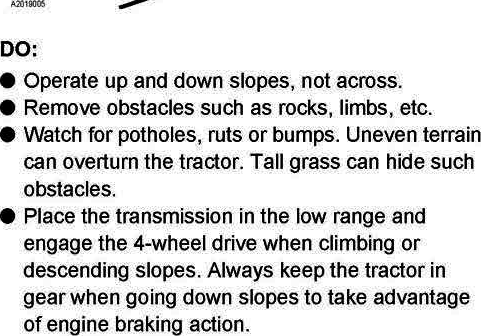

In [67]:
# --- Run WITHOUT image input ---
out1 = test_question_with_optional_input_image(
    query="What should we do when the tractor gets stuck in a muddy portion in field?",
    top_n_text=5,
    top_n_img=1
)


 QUESTION AND INPUTS
What does this image show and how does it relate to the document?

 INPUT IMAGE QUERY PATH:
./out_images/ym358a/page_011/page_011_img_01_crop_01.png


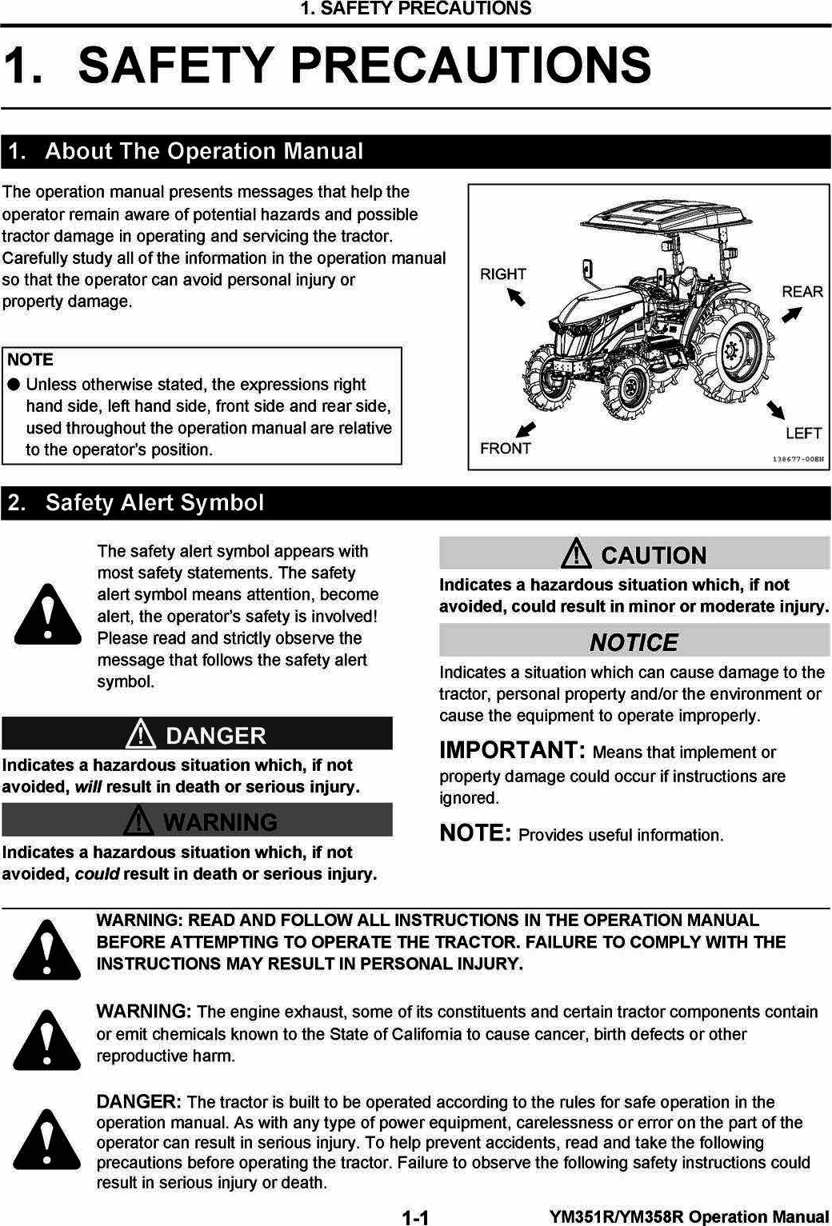




 ANSWER (TEXT) 
not available in the context

=== TOP MATCHED IMAGE ===
score: 0.95
file: ym358a.pdf | page: 12
path: ./out_images/ym358a/page_012/page_012_img_01_crop_01.png

caption/desc:
The image provides safety precautions before operating the tractor.

The precautions include:
*   Understanding the tractor's performance and limitations.
*   Following safety decals.
*   Not operating the tractor with the Roll-Over Protective Structure (ROPS) in the folded "down" position.
*   Always fastening the retractable seatbelt while operating the tractor with the ROPS in the unfolded "up" position.
*   Checking overhead clearance.
*   Ensuring the operator studies the operation manual.
*   Ensuring no person or obstacle is near the tractor.
*   Not operating the tractor under the influence of alcohol, drugs, medicine or controlled substances.
*   Wearing close-fitting clothing and avoiding loose clothing, jewelry, or torn clothing.
*   Not wearing cut-off pants or shorts.

It also advise

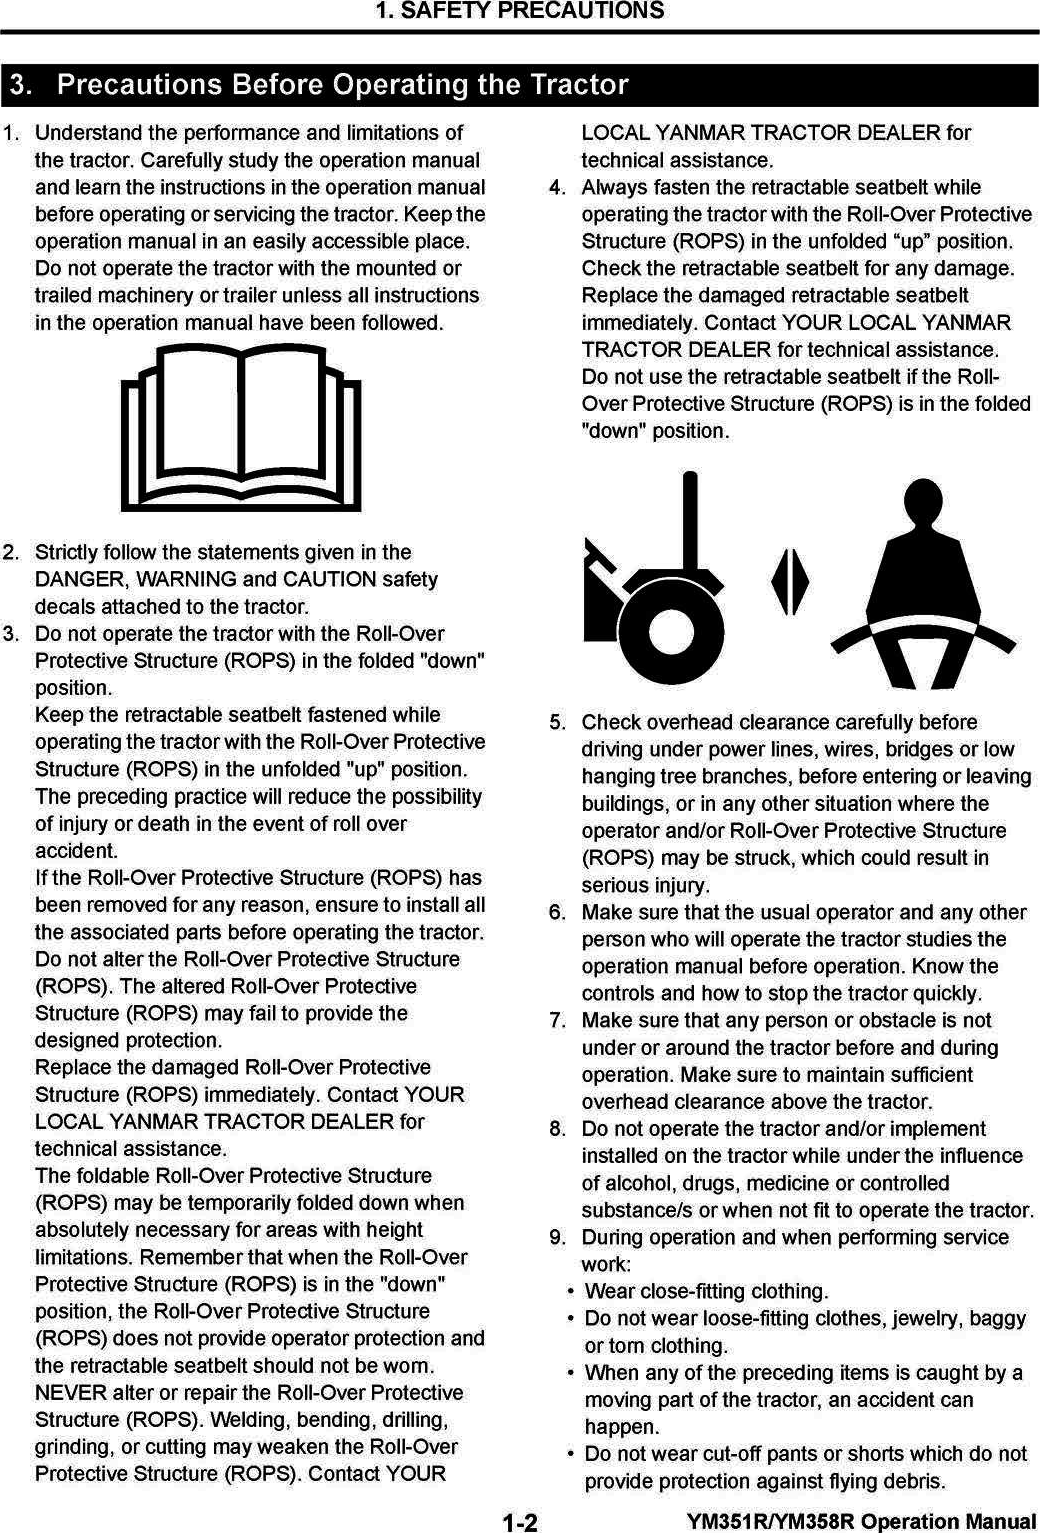

In [68]:

# --- Run WITH image input ---
out1b = test_question_with_optional_input_image(
    query="What does this image show and how does it relate to the document?",
    image_query_path="./out_images/ym358a/page_011/page_011_img_01_crop_01.png",
    top_n_text=5,
    top_n_img=1,
    embedding_size=128
)


 IMAGE QUERY INPUT 
./out_images/ym358a/page_011/page_011_img_01_crop_01.png
hint: table about results

 TOP IMAGE MATCHES FOR THE QUERY 

--- Match #1 ---
score: 0.95
file: ym358a.pdf | page: 12
path: ./out_images/ym358a/page_012/page_012_img_01_crop_01.png
desc: The image provides safety precautions before operating the tractor.

The precautions include:
*   Understanding the tractor's performance and limitations.
*   Following safety decals.
*   Not operating the tractor with the Roll-Over Protective Structure (ROPS) in the folded "down" position.
*   Always fastening the retractable seatbelt while operating the tractor with the ROPS in the unfolded "up" position.
*   Checking overhead clearance.
*   Ensuring the operator studies the operation manual.
*   Ensuring no person or obstacle is near the tractor.
*   Not operating the tractor under the influence of alcohol, drugs, medicine or controlled substances.
*   Wearing close-fitting clothing and avoiding loose clothing, jewelry, o

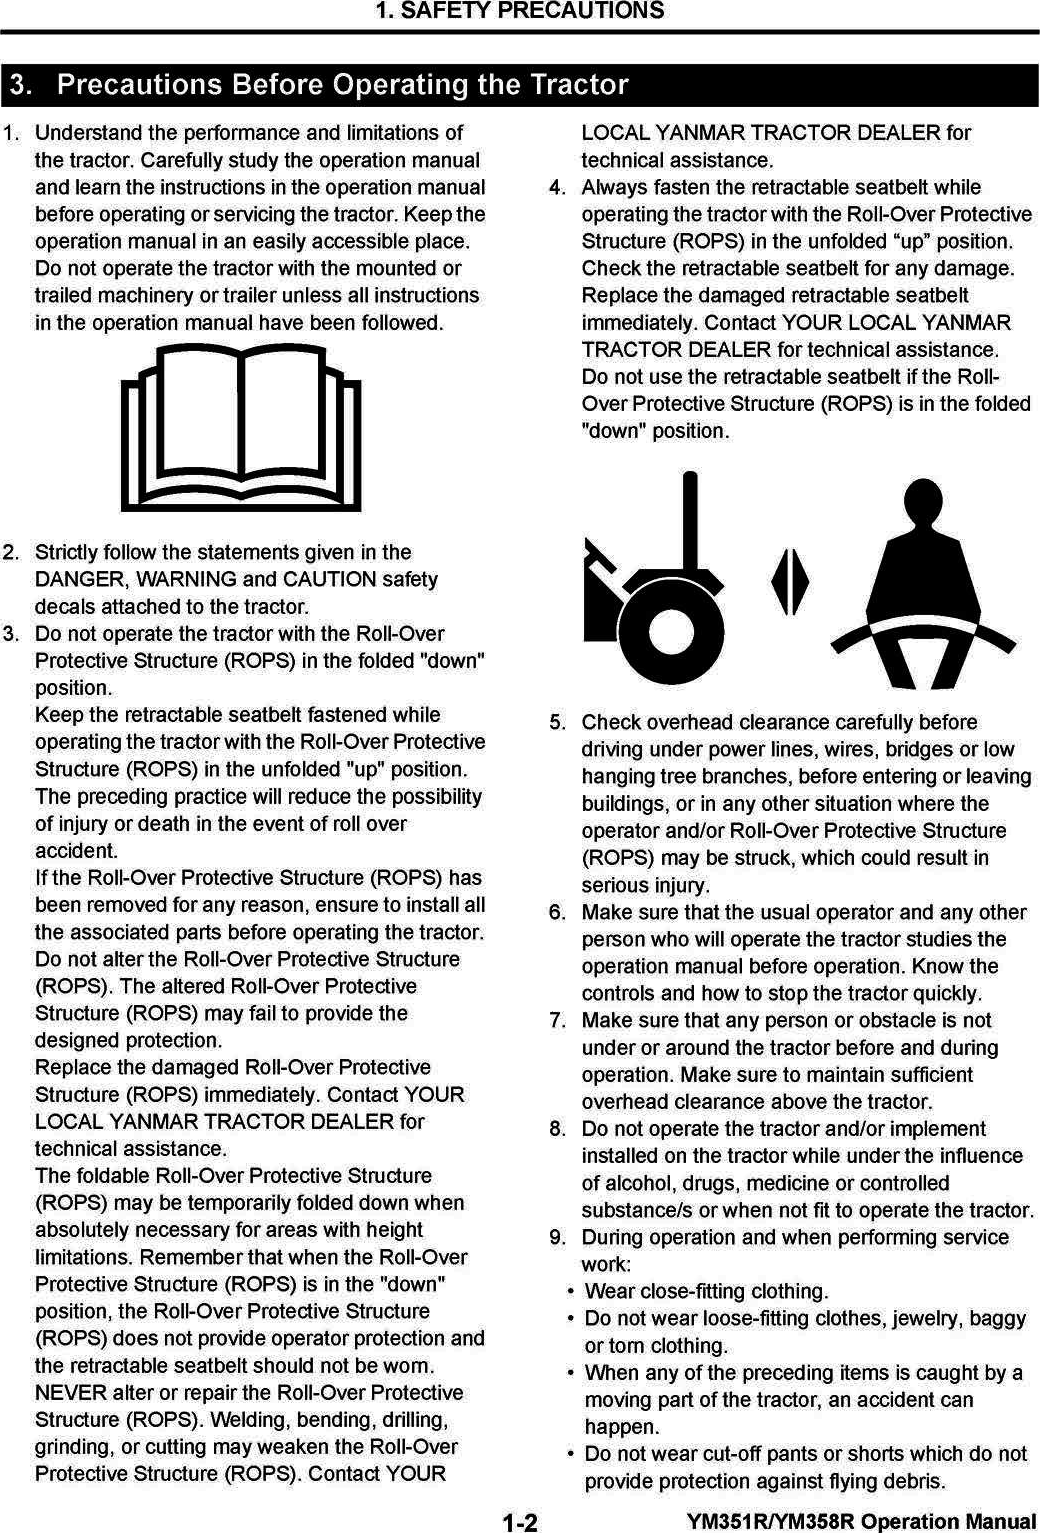


--- Match #2 ---
score: 0.95
file: ym358a.pdf | page: 13
path: ./out_images/ym358a/page_013/page_013_img_01_crop_01.png
desc: The image contains a list of safe practices for operating a tractor. The list is divided into sections, including how to start the tractor.

The safe practices include:
*   Remaining seated in the operator seat when starting the engine or actuating the levers or controls.
*   Ensuring that all the levers are in the N (neutral) positions, the parking brake is engaged securely, and Power Take Off (PTO) switch is in the OFF position before starting the engine.
*   Keeping the retractable seatbelt fastened around the operator's waist whenever the Roll-Over Protective Structure (ROPS) is in the unfolded "up" position and locked securely.
*   Returning the Roll-Over Protective Structure (ROPS) to the unfolded "up" position and locked securely and fastening the retractable seatbelt if the tractor is started where there is a height limitation.
*   Starting the engine o

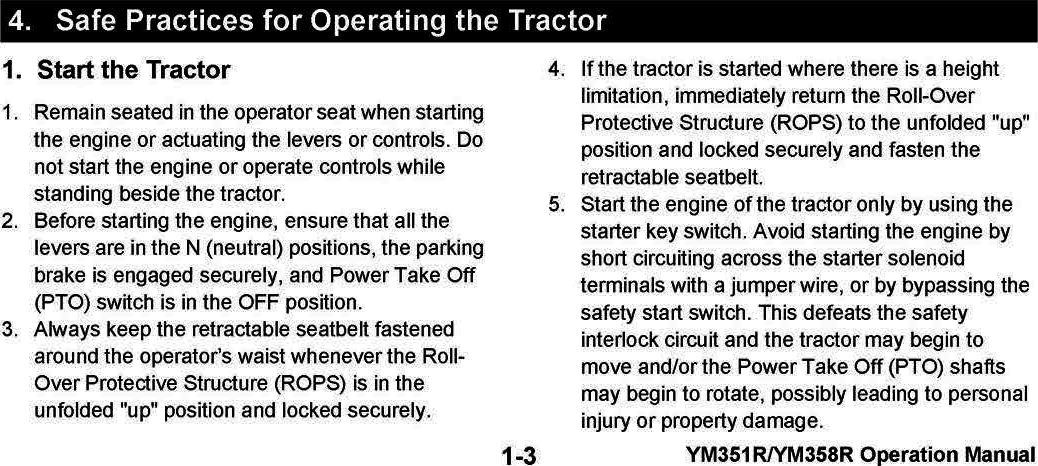


--- Match #3 ---
score: 0.94
file: ym358a.pdf | page: 5
path: ./out_images/ym358a/page_005/page_005_img_01_crop_01.png
desc: The image shows a table of contents. Here are the elements of the table:

**1. SAFETY PRECAUTIONS**
*   About The Operation Manual
*   Safety Alert Symbol
*   Precautions Before Operating the Tractor
*   Safe Practices for Operating the Tractor
    *   Start the Tractor
    *   Work with the Tractor
    *   Stop the Tractor
    *   Considerations for Safety of a Child
    *   Operate the Tractor on Slopes
*   Travel on a Road
*   Safe Practices for Parking the Tractor
*   Operate the Power Take Off (PTO)
*   Use the 3-Point Hitch
*   Roll-Over Protective Structure (ROPS) Precautions
*   Safe Practices for Servicing the Tractor
*   Replace the Rubber Product/s, such as Hydraulic Hose, Fuel Hoses, Power Steering Hoses, Radiator Hoses and Air Intake Hose for Every 2 Years
*   This Tractor is not Designed for Forest Industry, Quarry or Mining Use, nor Designed for U

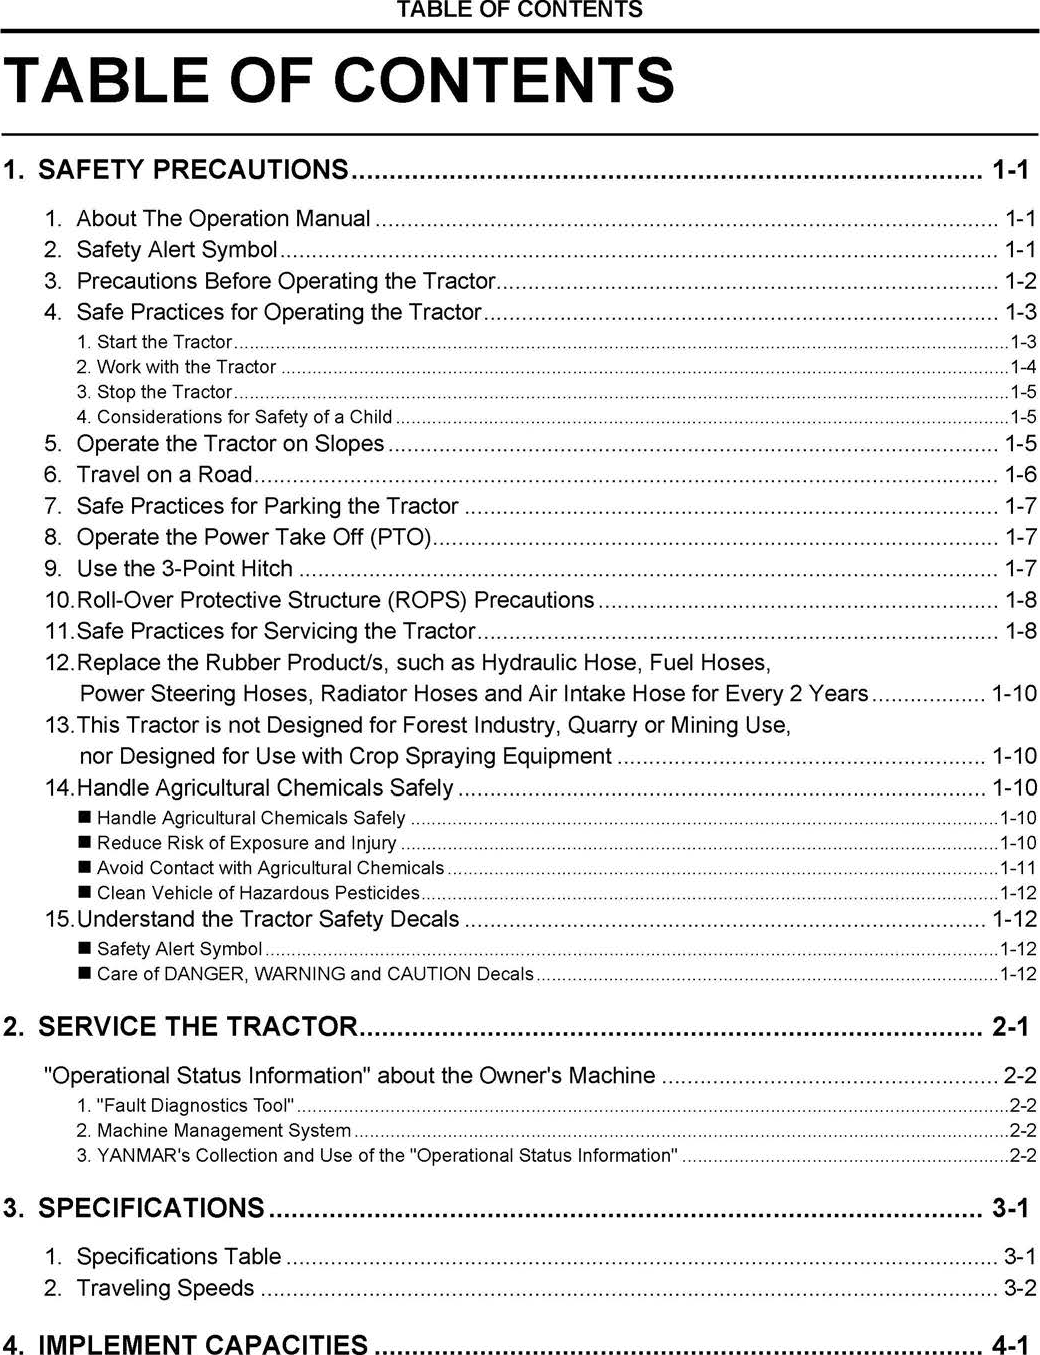

In [63]:
from IPython.display import display

def test_image_query(image_query_path: str, query_hint: str = "", top_n_img: int = 3, embedding_size: int = 128):
    print("\n IMAGE QUERY INPUT ")
    print(image_query_path)
    if query_hint:
        print("hint:", query_hint)

    # 1) retrieve similar images by image embedding
    matches = search_images_by_image_embedding(
        query=query_hint,
        image_query_path=image_query_path,
        top_n=top_n_img,
        column_name="mm_embedding_from_img_only",
        embedding_size=embedding_size,
    )

    print("\n TOP IMAGE MATCHES FOR THE QUERY ")
    for k, v in matches.items():
        print(f"\n--- Match #{k+1} ---")
        print("score:", v["cosine_score"])
        print("file:", v["file_name"], "| page:", v["page_num"])
        print("path:", v["img_path"])
        print("desc:", v["image_description"])

        try:
            display(v["image_object"])
        except Exception:
            try:
                display_images([v["img_path"]], resize_ratio=0.8)
            except Exception as e:
                print("Display error:", e)

        # 2) also show some text from same page (quick context)
        page_texts = v.get("page_text", [])
        if isinstance(page_texts, (list, tuple)) and len(page_texts) > 0:
            print("\n[page text sample]")
            print(str(page_texts[0])[:800], "...\n")

    return matches


# --- Run a test ---
# Put a real image path you want to query with (e.g., one of your cropped images)
out2 = test_image_query(
    image_query_path="./out_images/ym358a/page_011/page_011_img_01_crop_01.png",
    query_hint="table about results",   # optional hint; can be ""
    top_n_img=3,
    embedding_size=128
)